# Exercise 1 - Smoothing and Interpolation

## Introduction
This exercise is about smoothing and interpolating medical images using B-spline basis functions. First, you will implement the principle on a one-dimensional signal, and then expand it to an image in 2D.

### Instructions for your report
Your report should be structured as follows:
* **Introduction**: a short summary of what your report is about, perhaps with a recap of some of the equations you'll be using in your solution.
* **Task 1, ..., 5**: for each specific task listed below, your code (in code cells), your results (as figures) as well as explanations of what is computed and what is shown in the figures (in Markdown cells). 
* **Conclusion**: a short summary of your findings.

This introduction should **not** be part of your report.

### Input data and code hints
Import Python libraries

In [1]:
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt

np.set_printoptions( suppress=True )
plt.style.use('dark_background') # Dark theme
plt.ion()

Read a 3D image (an MRI scan of the brain) and extract the 2D slice you'll be working with in this exercise:

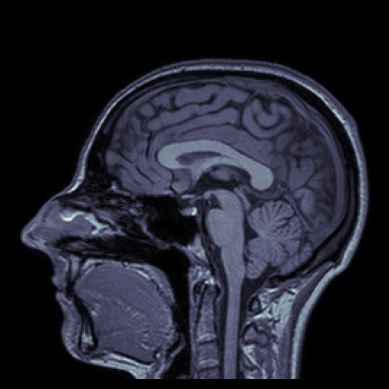

In [2]:
T1_file = './IXI002-Guys-0828-T1.nii.gz'
T1_nib = nib.load( T1_file )
data = T1_nib.get_fdata()

img = data[:, :, 75]
T = np.flipud( img.T )

plt.axis('off')
plt.imshow(T, cmap='bone');

Extract the 1D signal you'll be working with as the middle row of the 2D image

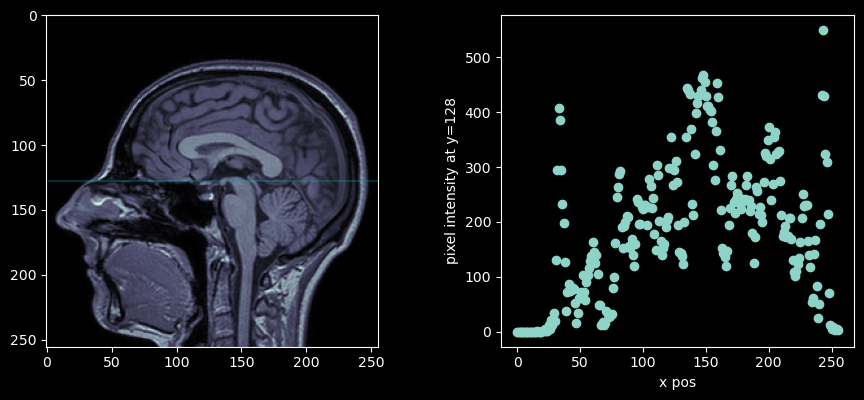

In [3]:
row = round( T.shape[0] / 2 )
t = T[row, :] #pixel intensity at row y = 128

N = t.shape[0]
x = np.arange(0, N)

# plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
fig.tight_layout(pad=5.0)

ax[0].imshow(T, cmap='bone')
ax[0].hlines(row, xmin=1, xmax=255, alpha=0.25, color='c')

ax[1].scatter(x, t)
ax[1].set_xlabel('x pos')
ax[1].set_ylabel('pixel intensity at y={}'.format(row))

plt.show();

---
## Task 1: B-splines basis functions
Implement a function that evaluates the uniform B-spline of orders 0, 1 and 3 at the locations provided in a vector $\mathbf{x}$. 

The function should return a vector $\mathbf{y}$ that is the same length as $\mathbf{x}$:

    def eval_BSpline(x, order=0):

        """
        Evaluates the uniform B-spline of order "order" at the locations in vector "x"
        """

        ...

        return y


Use this function to plot the uniform B-spline of orders 0, 1 and 3 at locations:  $\mathbf{x} = [-3.0,-2.99,-2.98, \ldots, 2.99,3.0]$

> ***Hint:*** use the function ```np.arange()``` to obtain $\mathbf{x}$.

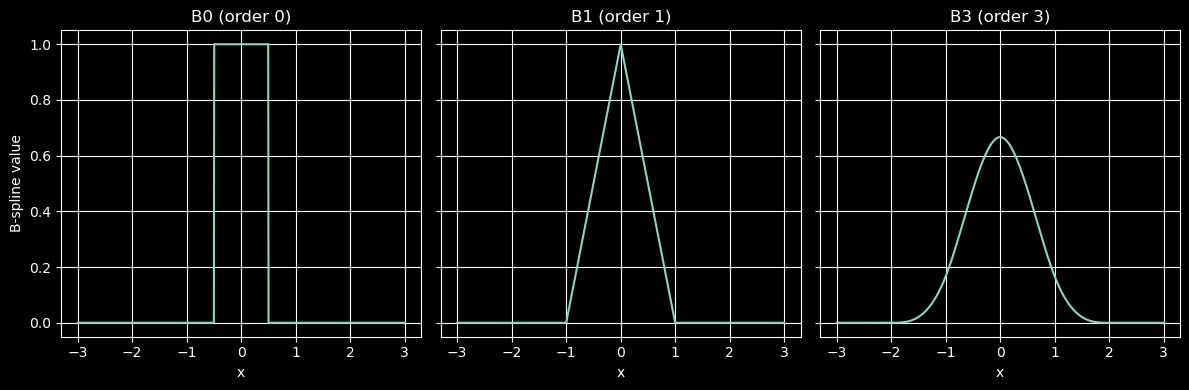

In [4]:
Locs = np.linspace(-3, 3, 1000)

#We first make some functions for evaulation of the different spline fammilies:
def B0(x):
    #Allocate space:
    B0x = np.zeros((len(x))) 
    B0x = np.zeros_like(x, dtype=float)

    # First interval
    B0x[(-0.5 < x) & (x < 0.5)] = 1.0

    # Boundery
    B0x[np.isclose(np.abs(x), 0.5)] = 0.5

    return B0x

def B1(x):
    #Allocate space:
    B1x = np.zeros((len(x))) 
    B1x = np.zeros_like(x, dtype=float)

    # 
    idx = np.abs(x)<1
    B1x[idx] = 1.0-np.abs(x[idx])

    return B1x

def B3(x):
    #Allocate space:
    B3x = np.zeros((len(x))) 
    B3x = np.zeros_like(x, dtype=float)

    # 
    idx = np.abs(x)<1 #Indicies where it is true for the first inteval, could also have used np.where i think.
    B3x[idx] = (2/3)-np.abs(x[idx])**2+(np.abs(x[idx])**3)/2
    idx = (1 <= np.abs(x)) & (np.abs(x)<2)
    B3x[idx] = ((2-np.abs(x[idx]))**3)/6

    return B3x

def eval_BSpline(x, order=0):
    """
    Evaluates the uniform B-spline of order "order" at the locations in vector "x"
    """
    # First it seems we need to construct some basis functions, one for each case. And then use an if statement to switch between what is used.
    if order == 0:
        return B0(x)
    elif order == 1:
        return B1(x)
    elif order == 3:
        return B3(x)
    else:
        raise ValueError("Order not implemented")


#And now we test with some plotting:
y0 = eval_BSpline(x = Locs, order = 0)
y1 = eval_BSpline(x = Locs, order = 1)
y3 = eval_BSpline(x = Locs, order = 3)

#now plot it:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axes[0].plot(Locs, y0, label="B0")
axes[0].set_title("B0 (order 0)")
axes[0].grid(True)

axes[1].plot(Locs, y1, label="B1")
axes[1].set_title("B1 (order 1)")
axes[1].grid(True)

axes[2].plot(Locs, y3, label="B3")
axes[2].set_title("B3 (order 3)")
axes[2].grid(True)

for ax in axes:
    ax.set_xlabel("x")
axes[0].set_ylabel("B-spline value")

plt.tight_layout()

---
## Task 2: Smoothing
Using the function you wrote above for evaluating a uniform B-spline of order 3, generate $M=6$ basis functions covering the entire domain $x=0,1,\ldots, 255$ of the 1D signal $\mathbf{t}$ defined in the introduction (which has length $N=256$). 

The basis functions should be scaled by a factor $h=(N-1)/(M-1)$, and shifted to be $h$ units apart (see book). 

Collect the obtained basis functions in a $N \times M$ matrix $\boldsymbol{\Phi}$, and plot them.

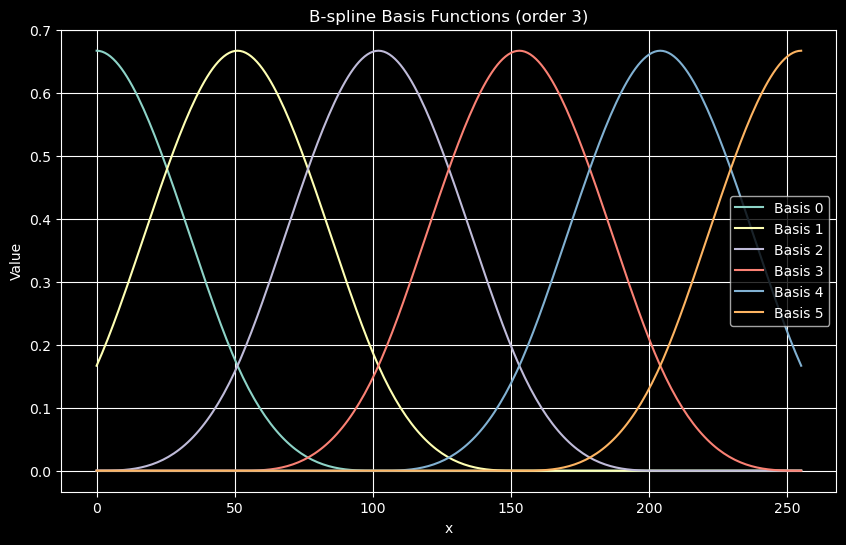

In [5]:
N = len(t)
locs = np.arange(N)
M = 6
h = (N-1)/(M-1)

#make a for-loop and fill a matrix:

phi = np.zeros((N,M))

for m in range(M):
    phi[:,m] = eval_BSpline(((locs-m*h)/h), order=3)

# Plot the basis functions
plt.figure(figsize=(10, 6))
for m in range(M):
    plt.plot(locs, phi[:, m], label=f"Basis {m}")

plt.title("B-spline Basis Functions (order 3)")
plt.xlabel("x")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


Compute:
- the smoothing matrix: $\mathbf{S} = \boldsymbol{\Phi} (\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T$
- the smoothed signal:  $\mathbf{\hat{t}} = \mathbf{S} \mathbf{t}$

Plots the results. Also plot the middle row of the smoothing matrix. 

>***Hint:*** 
>
> To compute the solution of a linear equation of the form Ax = b, you can use the following numpy function: ```np.linalg.solve(A, b)```. 
>
> You can also use the matrix inversion function ```np.linalg.inv()```, although this is numerically not the best solution.

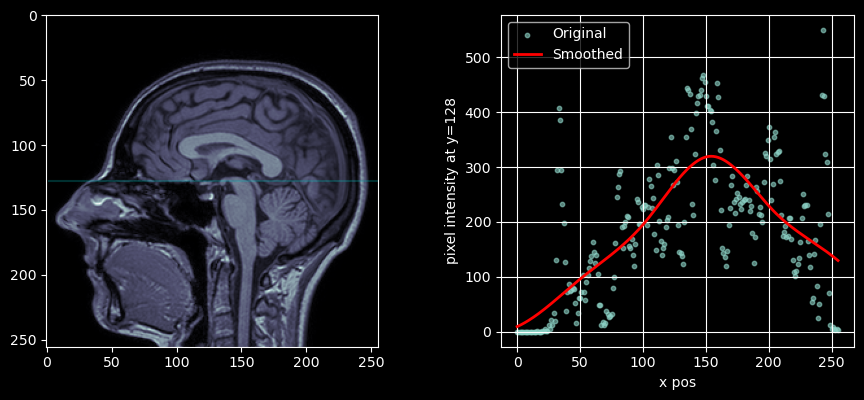

In [6]:
#Now that phi is computed, the rest should be straight forward. I dint wanna use inv, for the stated reason. Also for readability, i say fuck the one liners, eventhough they cool.

PhiProducts = phi.T@phi
InverseProduct = np.linalg.solve(PhiProducts,phi.T)
S = phi@InverseProduct

#And now for the smoothed signal:
t_hat = S@t 

row = round(T.shape[0] / 2)
t = T[row, :]  # pixel intensity at row y = 128

N = t.shape[0]
x = np.arange(0, N)

# plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.tight_layout(pad=5.0)

ax[0].imshow(T, cmap='bone')
ax[0].hlines(row, xmin=1, xmax=255, alpha=0.25, color='c')

# original scatter
ax[1].scatter(x, t, s=10, label="Original", alpha=0.6)

# smoothed line
ax[1].plot(x, t_hat, color="red", linewidth=2, label="Smoothed")

ax[1].set_xlabel("x pos")
ax[1].set_ylabel(f"pixel intensity at y={row}")
ax[1].legend()
ax[1].grid(True)

plt.show()


Now repeat the same experiment when more basis functions are used: $M=16$ and $M=52$. 

> ***Q?:*** How does the smoothing behavior change? Explain.

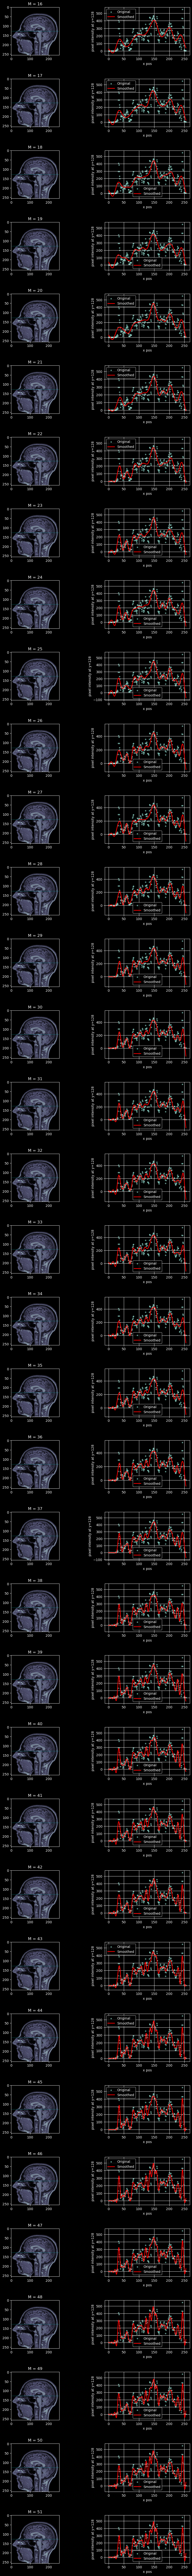

In [7]:
# We can make an outer for-loop and make all the plots below.

Ms = np.arange(16,52)


#Prepare a subfigure object to store generated figures in:
fig, axes = plt.subplots(len(Ms), 2, figsize=(10, 3*len(Ms)))
fig.tight_layout(pad=5.0)
#If we just copy the code and change M every iteration, we should get something that works.
#The copied code from before:
for i, M in enumerate(Ms):
    N = len(t)
    locs = np.arange(N)
    h = (N-1)/(M-1)

    #make a for-loop and fill a matrix:

    phi = np.zeros((N,M))

    for m in range(M):
        phi[:,m] = eval_BSpline(((locs-m*h)/h), order=3)

    #Now that phi is computed, the rest should be straight forward. I dint wanna use inv, for the stated reason. Also for readability, i say fuck the one liners, eventhough they cool.

    PhiProducts = phi.T@phi
    InverseProduct = np.linalg.solve(PhiProducts,phi.T)
    S = phi@InverseProduct

    #And now for the smoothed signal:
    t_hat = S@t 

    row = round(T.shape[0] / 2)
    t = T[row, :]  # pixel intensity at row y = 128

    N = t.shape[0]
    x = np.arange(0, N)

    # smoothed signal (already computed)
    t_hat = S @ t

    # We need to change the plotting code:
    #Dont think we need this image anymore, but it makes coping easier so we just leave it around.
    axes[i, 0].imshow(T, cmap='bone')
    axes[i, 0].hlines(row, xmin=1, xmax=255, alpha=0.25, color='c')
    axes[i, 0].set_title(f"M = {M}")

    # original + smoothed, like before.
    axes[i, 1].scatter(x, t, s=10, label="Original", alpha=0.6)
    axes[i, 1].plot(x, t_hat, color="red", linewidth=2, label="Smoothed")
    axes[i, 1].set_xlabel("x pos")
    axes[i, 1].set_ylabel(f"pixel intensity at y={row}")
    axes[i, 1].legend()
    axes[i, 1].grid(True)


I mean, in machine learning i would just call this overfitting, when N=M no smoothing is really done, right?.

---
## Task 3: Interpolation
Implement B-spline interpolation of the 1D signal $\mathbf{t}$, by evaluating the function $y( x, \mathbf{w})$ at locations $x = [120, 120.01, 120.02, \ldots 140]$

Show your results, along with the corresponding part of the signal $\mathbf{t}$, for three different orders of B-splines: 0, 1 and 3.

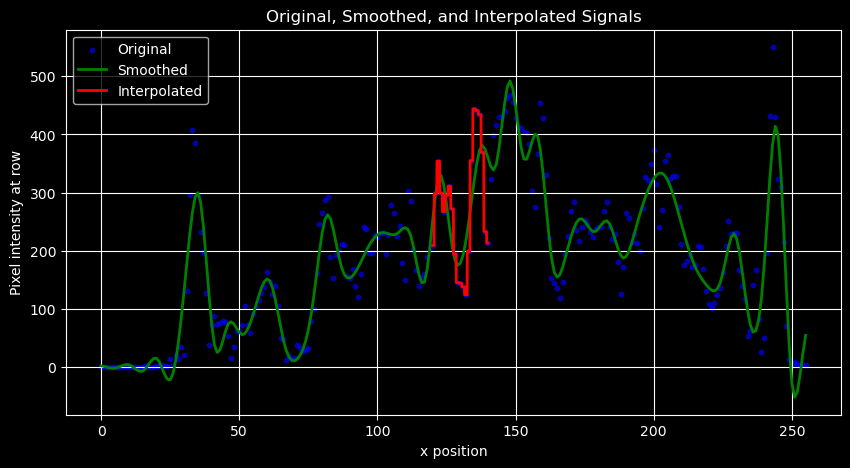

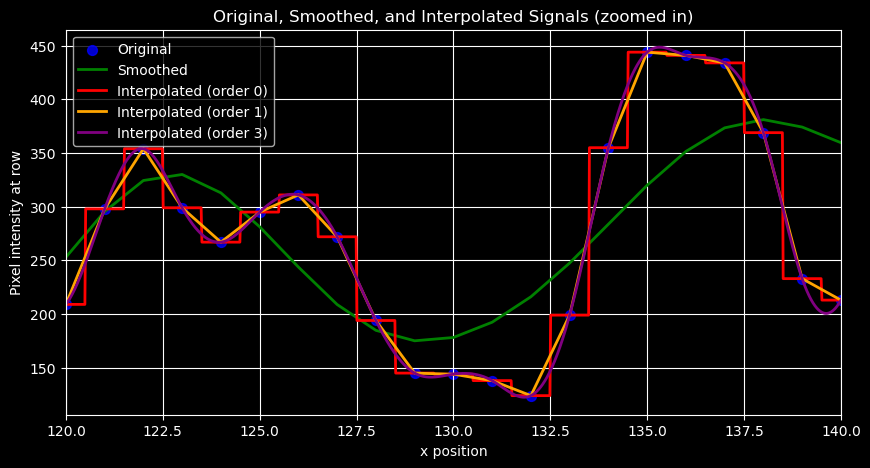

In [30]:
# We can look in the book for the math that can find the weights.
x_Interp = np.arange(120, 140 + 0.01, 0.01)
N = len(t)
locs = np.arange(N)
M = N #Also defined in the book for interpolation.
h = 1 #As defined in the book for interpolation
#We make a quick function for generating the basis, as i dont wanna do that anymore. 
# #Nevermind we dont need S i think.
def GeneratePhiMatrix(x, order, N, M, h):
    phi = np.zeros((N,M))

    for m in range(M):
        phi[:,m] = eval_BSpline(((x-m*h)/h), order)

    #PhiProducts = phi.T@phi
    #InverseProduct = np.linalg.solve(PhiProducts,phi.T)
    #S = phi@InverseProduct
    return phi #We return a tuple with the matricies. Nvm i changed it.




# Now we can use phi to generate the weights.
def GenerateWeights(phi, t):
    return np.linalg.solve(phi,t)

#Make a list to save results:
t_interp = []
for order in np.array([0, 1, 3]):
    #And we find the weights:
    phi = GeneratePhiMatrix(locs, order, N, M, h) #Might be able to make it cleaner without the tuple, but whatevs, we might need it later.
    W = GenerateWeights(phi, t)

    N_x = len(x_Interp)
    #So now we just need the phi matrix for our x_interp and we are done.
    Phix = GeneratePhiMatrix(x_Interp, order, N_x, M, h)

    #And the interpolated signal must be:
    t_interp.append(Phix @ W)

#And we plot:
N = len(t)
x = np.arange(N)  # original x-axis

plt.figure(figsize=(10, 5))

# Original signal
plt.scatter(x, t, s=10, label="Original", alpha=0.6, color='blue')

# Smoothed signal from before
plt.plot(x, t_hat, color='green', linewidth=2, label="Smoothed")

# Interpolated signal
plt.plot(x_Interp, t_interp[0], color='red', linewidth=2, label="Interpolated")

plt.xlabel("x position")
plt.ylabel(f"Pixel intensity at row")
plt.title("Original, Smoothed, and Interpolated Signals")
plt.legend()
plt.grid(True)
plt.show()

#And we zoom in, but i didnt wanna do it so i made ChatGPT do it.
x = np.arange(N)  # original x-axis

plt.figure(figsize=(10, 5))

# Original signal (scatter only in interpolation interval)
mask = (x >= x_Interp.min()) & (x <= x_Interp.max())
plt.scatter(x[mask], t[mask], s=50, label="Original", alpha=0.8, color='blue')

# Smoothed signal (only plot inside interval)
plt.plot(x[mask], t_hat[mask], color='green', linewidth=2, label="Smoothed")

orders = [0, 1, 3]
colors = ['red', 'orange', 'purple']
for i, order in enumerate(orders):
    plt.plot(x_Interp, t_interp[i], color=colors[i], linewidth=2, label=f"Interpolated (order {order})")

# Zoom to interpolation interval
plt.xlim(x_Interp.min(), x_Interp.max())

plt.xlabel("x position")
plt.ylabel("Pixel intensity at row")
plt.title("Original, Smoothed, and Interpolated Signals (zoomed in)")
plt.legend()
plt.grid(True)
plt.show()


**Looks a little overfitted maybe**

But it works so whatevs

---
## Task 4: Smoothing in 2D
Now you are going to smooth the 2D image $\mathbf{T}$, which has dimensions $N_1 \times N_2 = 256 \times 256$, with $M_1=M_2=5$ B-spline-based 1D basis functions of order 3 for each direction.

Use the Kronecker product to produce a $N \times M$ matrix $\boldsymbol{\Phi} = \boldsymbol{\Phi}_2 \otimes \boldsymbol{\Phi}_1$, where:
- $N=N_1 N_2$ 
- $M = M_1 M_2$. 

Show a few 2D basis functions contained in the columns of $\boldsymbol{\Phi}$.

>***Hints***:
>* the Kronecker product of two matrices A and B can be calculated with ```np.kron(A, B)```
>* for converting a vectorized basis function ```v``` back into its 2D shape, use ```v.reshape(N_1, N_2, order='F')```
>* the following snippet can be used to show a 2D basis function:
>    ```
>        plt.figure(); 
>        ax = plt.axes(projection='3d'); 
>        ax.plot_wireframe(np.arange(N1).reshape(-1, 1), np.arange(N2).reshape(1, -1), basisFunction)
>
>    ```

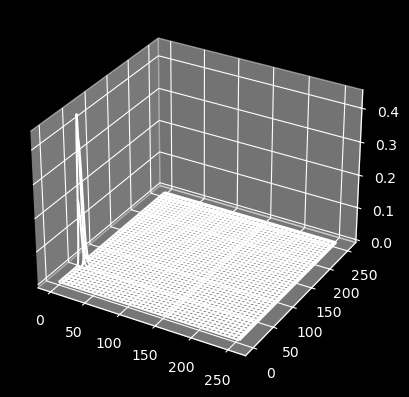

In [19]:
#We can use the function that we had from before. We need to make both phi_1 and phi_2 and then calculate the product.
M1 = 50
M2 = 50
N1 = T.shape[0]
N2 = T.shape[1]

#So now we construct the basis like earlier.
#Fist basis
locs1 = np.arange(N1)
h1 = (N1-1)/(M1-1) 
Phi1 = GeneratePhiMatrix(locs1, 3, N1, M1, h1)
#And the other basis
locs2 = np.arange(N2)
h2 = (N2-1)/(M2-1) 
Phi2 = GeneratePhiMatrix(locs2, 3, N2, M2, h2)

# In this case because N1=N2 and M1=M2 we dont care about direction, and they are essencially idendical.
PHI_2d = np.kron(Phi2, Phi1)

#And we make a function for it aswell.
def GeneratePhi2D(M1, M2, N1, N2, order):
    locs1 = np.arange(N1)
    h1 = (N1-1)/(M1-1) 
    Phi1 = GeneratePhiMatrix(locs1, order, N1, M1, h1)
    #And the other basis
    locs2 = np.arange(N2)
    h2 = (N2-1)/(M2-1) 
    Phi2 = GeneratePhiMatrix(locs2, order, N2, M2, h2)

    # In this case because N1=N2 and M1=M2 we dont care about direction, and they are essencially idendical.
    PHI_2d = np.kron(Phi2, Phi1)
    return PHI_2d

#And we try the plotting code:
#First we extract a basis function:
basisidx = 10
BasisFunc = PHI_2d[:,basisidx]
#And we need to reshape into the correct format, N1, N2.
BasisFunc = BasisFunc.reshape(N1, N2)
plt.figure(); 
ax = plt.axes(projection='3d'); 
ax.plot_wireframe(np.arange(N1).reshape(-1, 1), np.arange(N2).reshape(1, -1), BasisFunc)

#And we can basically plot any of them now.

Now:
- vectorize the 2D image $\mathbf{T}$ into a 1D signal $\mathbf{t}$
- smooth using $\boldsymbol{\Phi}$
- re-arrange the resulting 1D signal $\mathbf{\hat{t}}$ back into a 2D image $\mathbf{\hat{T}}$
- show the result.

>***Hints***: 
>* use ```T.reshape(-1, 1, order='F')``` and ```t.reshape(N_1, N_2, order='F')``` to vectorize and undo the vectorization.
>* do not explicitly compute the smoothing matrix $\mathbf{S}$ as it is very large!! Instead compute the weights $\mathbf{w} = (\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T \mathbf{t}$ and expand those to get $\mathbf{\hat{t}} = \boldsymbol{\Phi} \mathbf{w}$.


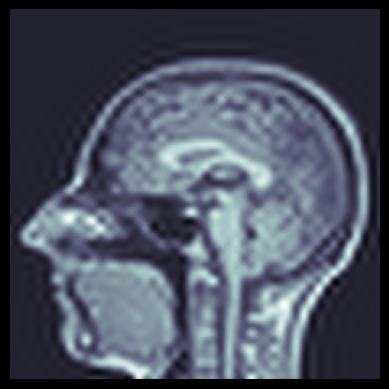

In [20]:
# We reshape:
T_Reshaped = T.reshape(-1,1, order='F') #But we dont need it because we made a function instead ;P

# We now need to compute the weights, which we can do simmilarly to before:
#We make a new function for it:
def Calculate_Weight_2d(Image, M1, M2, order):
    N1 = Image.shape[0]
    N2 = Image.shape[1]
    Phi2d = GeneratePhi2D(M1, M2, N1, N2, order)
    #Reshape image:
    img_Reshaped = Image.reshape(-1, 1, order='F')
    W = np.linalg.solve((Phi2d.T@Phi2d), Phi2d.T@img_Reshaped)
    return W


W = Calculate_Weight_2d(T, M1, M2, 3)
#And now we can calculate t_hat:
T_hat = PHI_2d@W

#And lets plot it:
#But lets remember to reshape XD.
T_hat_img = T_hat.reshape(N1, N2, order = 'F')
plt.axis('off')
plt.imshow(T_hat_img, cmap='bone');

Might need some more basis, this is a very smooth brain image.

Also perform the same smoothing operation by exploiting the separability of the 2D basis functions, i.e, perform row-wise and then column-wise smoothing instead. 

Show the results, and verify that they are identical (use ```np.allclose()```) 

True
1.0231815394945443e-12
(256, 50)
(256, 50)
(50, 50)
True
6.764366844436154e-12


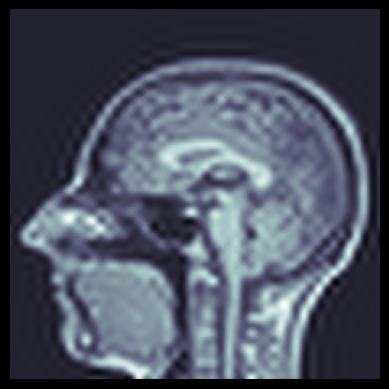

In [25]:
#We basically just implement 1.13

#We make a function for making it like before.
#First phi1 and phi2
def Generate_Phi1_Phi2(M1, M2, N1, N2, order):
    locs1 = np.arange(N1)
    h1 = (N1-1)/(M1-1) 
    Phi1 = GeneratePhiMatrix(locs1, order, N1, M1, h1)
    #And the other basis
    locs2 = np.arange(N2)
    h2 = (N2-1)/(M2-1) 
    Phi2 = GeneratePhiMatrix(locs2, order, N2, M2, h2)
    return (Phi1, Phi2) #Return a tuple

#And now one for calculating W.
def Calculate_W(img, M1, M2, order):
    N1 = img.shape[0]
    N2 = img.shape[1]
    Phi1, Phi2 = Generate_Phi1_Phi2(M1, M2, N1, N2, order)
    #Now make W from 1.13
    W = (np.linalg.solve(Phi1.T@Phi1, Phi1.T@img@Phi2))@(np.linalg.inv(Phi2.T@Phi2))#Theres probably another fast way of doing this using linear algebra, but i dunno. Maybe a Cholesky solve or something.
    return W

W1 = Calculate_W(T, M1, M2, 3)

#Chat GPT suggests doing it another way, that might be faster and more numerically stable because we avoid inv.
def Calculate_W_Chat(img, M1, M2, order):
    N1 = img.shape[0]
    N2 = img.shape[1]
    Phi1, Phi2 = Generate_Phi1_Phi2(M1, M2, N1, N2, order)

    A = Phi1.T @ Phi1
    B = Phi2.T @ Phi2
    C = Phi1.T @ img @ Phi2

    Y = np.linalg.solve(A, C)        # A^{-1} C
    W = np.linalg.solve(B, Y.T).T    # Y B^{-1}
    return W

W2 = Calculate_W_Chat(T, M1, M2, 3)

#Check if they equal:
print(np.allclose(W1, W2, rtol=1e-05, atol=1e-05, equal_nan=False))
print(np.max(np.abs(W1 - W2)))

#So the fancy other way works too, great to know in the furture.
Phi1, Phi2 = Generate_Phi1_Phi2(M1, M2, T.shape[0], T.shape[1], 3)
# Now we need to make T_hat for this case and check if they are equal.
print(Phi1.shape)
print(Phi2.shape)
print(W2.shape)
T_hat_efficient = Phi1@W1@Phi2.T

#Check if it is the same:
print(np.allclose(T_hat_img, T_hat_efficient, rtol=1e-05, atol=1e-05, equal_nan=False))
print(np.max(np.abs(T_hat_img - T_hat_efficient)))

#Indeed they are the same.
#Plot alsp
plt.axis('off')
plt.imshow(T_hat_efficient, cmap='bone');


---
## Task 5: Interpolation in 2D
For B-spline order 0, 1 and 3, compute the weights $\mathbf{W}$ of the 2D interpolation model fitted to $\mathbf{T}$ by exploiting the separability of its basis functions.

Then show, as an image, interpolated function values $y( \mathbf{x}, \mathbf{w})$ for $\mathbf{x}=(x_1, x_2)^T$ with:
- $x_1=120.0, 120.1, 120.2 \ldots, 130.0$ 
- $x_2=120.0, 120.1, 120.2 \ldots, 130.0$ 

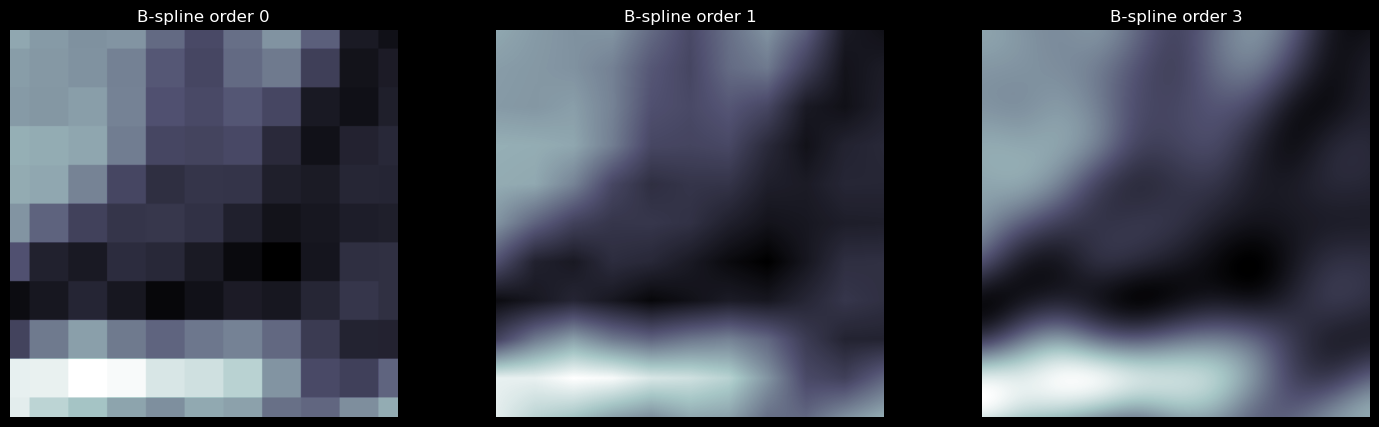

(1001, 1001)


In [ ]:
#First we need the weights.
Weight_List = [] #make a list to save them in.
#Now the basis.
BasisList = []
#And the location vectors.
locs1 = np.arange(120, 130 + 0.01, 0.01)
locs2 = np.arange(120, 130 + 0.01, 0.01)
#And a list for T_hats.
T_hat_list = []
#But we need a new function for it, as we are now dealing with locations instead.

def Generate_W_Interp(image, order):
    N1 = img.shape[0]
    N2 = img.shape[1]
    M1 = N1
    M2 = N2
    Phi1, Phi2 = Generate_Phi1_Phi2(M1, M2, N1, N2, order)
    W = np.linalg.solve(Phi1, image)@(np.linalg.inv(Phi2).T)
    return W

def Generate_Phi1_Phi2_Locs(locs1, locs2, M1, M2, order):
    N1 = len(locs1)
    h1 = 1#(N1-1)/(M1-1) 
    Phi1 = GeneratePhiMatrix(locs1, order, N1, M1, h1)

    N2 = len(locs2)
    h2 = 1#(N2-1)/(M2-1) 
    Phi2 = GeneratePhiMatrix(locs2, order, N2, M2, h2)

    return Phi1, Phi2

#Run the loop.
orders = np.array([0, 1, 3])
for order in orders:
    W = Generate_W_Interp(T, order)
    Weight_List.append(W)
    M1 = T.shape[0]
    M2 = T.shape[1]
    Basis = Generate_Phi1_Phi2_Locs(locs1, locs2, M1, M2, order)
    BasisList.append(Basis)
    #We just save them for fun...
    #Now we can calculate the interpolated values.
    T_hat_list.append(Basis[0]@W@Basis[1].T)

#I hate making plotting code, so i made CHATGPT make it:
# Number of images
n_images = len(T_hat_list)

# Create subplots
fig, axes = plt.subplots(1, n_images, figsize=(15, 5))  # 1 row, n_images columns
fig.tight_layout(pad=3.0)

for i in range(n_images):
    ax = axes[i]
    ax.imshow(T_hat_list[i], cmap='bone')
    ax.axis('off')
    ax.set_title(f'B-spline order {orders[i]}', fontsize=12)

plt.show()

#looks fine.
print(T_hat_list[0].shape)

And now, just for fun, lets try the whole image:

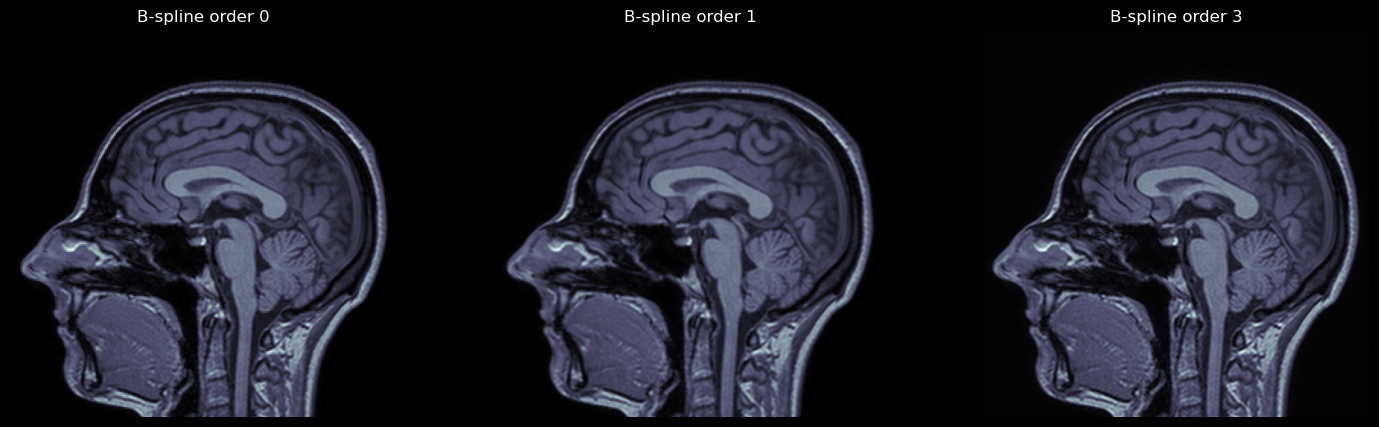

(2551, 2551)


In [ ]:
#First we need the weights.
Weight_List = [] #make a list to save them in.
#Now the basis.
BasisList = []
#And the location vectors. Maybe we dont need a grid that fine.
step = 0.1
locs1 = np.arange(0, 255 + step, step)
locs2 = np.arange(0, 255 + step, step)
#And a list for T_hats.
T_hat_list = []
#But we need a new function for it, as we are now dealing with locations instead.

def Generate_W_Interp(image, order):
    N1 = img.shape[0]
    N2 = img.shape[1]
    M1 = N1
    M2 = N2
    Phi1, Phi2 = Generate_Phi1_Phi2(M1, M2, N1, N2, order)
    W = np.linalg.solve(Phi1, image)@(np.linalg.inv(Phi2).T)
    return W

def Generate_Phi1_Phi2_Locs(locs1, locs2, M1, M2, order):
    N1 = len(locs1)
    h1 = 1#(N1-1)/(M1-1) 
    Phi1 = GeneratePhiMatrix(locs1, order, N1, M1, h1)

    N2 = len(locs2)
    h2 = 1#(N2-1)/(M2-1) 
    Phi2 = GeneratePhiMatrix(locs2, order, N2, M2, h2)

    return Phi1, Phi2

#Run the loop.
orders = np.array([0, 1, 3])
for order in orders:
    W = Generate_W_Interp(T, order)
    Weight_List.append(W)
    M1 = T.shape[0]
    M2 = T.shape[1]
    Basis = Generate_Phi1_Phi2_Locs(locs1, locs2, M1, M2, order)
    BasisList.append(Basis)
    #We just save them for fun...
    #Now we can calculate the interpolated values.
    T_hat_list.append(Basis[0]@W@Basis[1].T)

#I hate making plotting code, so i made CHATGPT make it:
# Number of images
n_images = len(T_hat_list)

# Create subplots
fig, axes = plt.subplots(1, n_images, figsize=(15, 5))  # 1 row, n_images columns
fig.tight_layout(pad=3.0)

for i in range(n_images):
    ax = axes[i]
    ax.imshow(T_hat_list[i], cmap='bone')
    ax.axis('off')
    ax.set_title(f'B-spline order {orders[i]}', fontsize=12)

plt.show()

#looks fine.
print(T_hat_list[0].shape)

I mean, the third image looks pretty good i guess.